In [1]:
######### Import package #########

# For data pre-processing
import torch
from torchvision.datasets import ImageFolder
import torch.utils.data as Data
from torchvision import transforms

# For net and model training
import torch.nn as nn
from torchvision.models import resnet18, resnet50, vgg16, resnet101, densenet121, densenet201, inception_v3

# For loss function and optimizer
import torch.nn as nn
import torch.optim as optim

# Other tools 
import gc
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [3]:
######### Set the hardware environment ######### 
'''
mps device can significantly accelerate the model training for Mac
If mps is available, then use mps and clear the current device memory, otherwise still use cpu

NOTICE: if your device is not mac, you should use cuda instead
Change 'mps' to 'cuda', change 'torch.backends.mps.is_available ()' to 'torch.cuda.is_available ()'
See https://www.techysqout.com/pytorch-check-if-gpu-is-available/ for more details

References: https://pytorch.org/docs/stable/notes/mps.html
'''

device = torch.device('mps' if torch.backends.mps.is_available () else 'cpu')
if device == torch.device('mps'): 
    gc.collect() 
    torch.mps.empty_cache()

In [7]:
######### Pre-process the imput images #########
'''
Since the size of the original image may not be consistent
we first resize the image to the same size, then convert it to tensor, and then normalize

References: https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html
'''
transform = transforms.Compose([
    transforms.Resize([224, 224]), #resize the image to the specified size
    transforms.ToTensor(), #convert the image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize the images (here using the mean and standard deviation of the ImageNet dataset)
])


'''
# Pre-process the imput images (new version, not that much satisfied for epoch20, maybe increase the epoch will be better)
# Modify the data enhancement section
# It does not work very well, so we currently do not use it here

transform = transforms.Compose([
    transforms.Resize([224, 224]), #resize the image to the specified size
    transforms.RandomHorizontalFlip(p=0.5), #allow images to flip left and right
    transforms.ColorJitter(brightness=0.4), #allow randomly change the brightness of the image
    transforms.ToTensor(), #convert the image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize the images (here using the mean and standard deviation of the ImageNet dataset)
])
'''

'\n# Pre-process the imput images (new version, not that much satisfied for epoch20, maybe increase the epoch will be better)\n# Modify the data enhancement section\n# It does not work very well, so we currently do not use it here\n\ntransform = transforms.Compose([\n    transforms.Resize([224, 224]), #resize the image to the specified size\n    transforms.RandomHorizontalFlip(p=0.5), #allow images to flip left and right\n    transforms.ColorJitter(brightness=0.4), #allow randomly change the brightness of the image\n    transforms.ToTensor(), #convert the image to tensor\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize the images (here using the mean and standard deviation of the ImageNet dataset)\n])\n'

In [8]:
######### Prepare the datasets ######### 
'''
We use the torchvision.datasets.ImageFolder to read images in bulk
We use torch.utils.data.DataLoader to read the data into batches to input data to the network

The folders of BreaKHis 400X are three folders (train, test, validation) manually divided by us
Each folder has its own subfolder (benign, malignant)
Datasets are read in a specific order, benign is 0 and malignant is 1

References: https://pytorch.org/vision/stable/datasets.html
'''

# Training datasets (371 benign, 777 malignant)
trainset = ImageFolder(root = '/Users/wangyufei/BIA4/project/BreaKHis 400X/train',transform = transform) #construct the dataset of the training set
train_loader = Data.DataLoader(trainset, batch_size=16, shuffle = True, num_workers=0) #construct the DataLoader of the training set

# Validation datasets (118 benign, 246 malignant)
valset = ImageFolder(root = '/Users/wangyufei/BIA4/project/BreaKHis 400X/validation',transform = transform) #construct the dataset of the validation set
val_loader = Data.DataLoader(valset, batch_size=2, num_workers=0) #construct the DataLoader of the validation set

# Test datasets (59 benign, 123 malignant)
testset = ImageFolder(root = '/Users/wangyufei/BIA4/project/BreaKHis 400X/test',transform = transform) #construct the dataset of the test set
test_loader = Data.DataLoader(testset, batch_size =2, num_workers=0) #construct the DataLoader of the test set

# Take a look at the category and label index
trainset.class_to_idx

{'benign': 0, 'malignant': 1}

In [4]:
######### Create the NET #########

'''
# NETS: resnet18
class ResNet18(nn.Module):

    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, 2) #adjust the output of the last fully connected layer to 2 dimensions

    def forward(self,x):
        return self.resnet(x)

model = ResNet18().to(device)
'''


# NETS: resnet50
class ResNet50(nn.Module):

    def __init__(self):
        super(ResNet50, self).__init__()
        self.resnet = resnet50(pretrained=True) #using the pre-trained model can speed up the convergence of the model and the results are generally good
        self.resnet.fc = nn.Linear(2048, 2) #adjust the output of the last fully connected layer to 2 dimensions

    def forward(self,x):
        return self.resnet(x)

model = ResNet50().to(device)


In [6]:
######### Loss functions and optimizers #########
'''
Here we define the loss function to calculate the difference between the true label and the predicted label
For optimizer, after many attempts we chose the SGD with Momentum, plain and simple, but very effective

References: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
'''

criterion = nn.CrossEntropyLoss() #usually crossEntropyLoss() for multi-, BCELoss() for bi-
optimizer = optim.SGD(model.parameters(), lr=0.00008, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) #haven't use this currently, will consider using it later

In [7]:
######### Prepare for model Training ######### 
'''
Here, We created two functions: 'train_one_epoch' and 'validation_one_epoch'

Using 'train_one_epoch' as an example
It enumerates data from the DataLoader, and on each pass of the loop does the following:
Gets a batch of training data from the train_loader
Save the images and labels into GPU (if the device is available)
Make predictions for an input batch
Zero the gradients for every batch
Calculate the loss for the predictions and true labels
Save and return the training loss and accuracy

We learned this part through the tutorials from the official PyTorch website
References: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
'''

def train_one_epoch(train_loader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    metric = 0.0
    total = 0.0

    for i, data in enumerate(train_loader): #use enumerate to track the batch
        images, labels = data #an 'input + label' pair
        images = images.to(device) #save images to GPU
        labels = labels.to(device) #save labels to GPU

        outs = model(images) #make predictions

        optimizer.zero_grad() #zero the gradients
        loss = criterion(outs, labels) #calculate the loss
        loss.backward()
        optimizer.step() #adjust learning weights

        #gather the data
        running_loss += loss.item()
        _, preds = torch.max(outs, 1)
        metric += (preds == labels).sum().item()
        total += labels.shape[0]

    train_loss = running_loss/total #calculate the training loss
    train_accuracy = 100*metric/total #convert to percentage

    return train_loss, train_accuracy    


'''
'validation_one_epoch' function is relatively the same as the 'train_one_epoch' function
But only calculate the loss without using the optimizer and loss.backward()
'''
def validation_one_epoch(val_loader, model, criterion):
    model.eval()
    running_loss = 0.0
    total = 0.0
    metric = 0.0

    for i, data in enumerate(val_loader): #use enumerate to track the batch
        images, labels = data #an 'input + label' pair
        images = images.to(device) #save images to GPU
        labels = labels.to(device) #save labels to GPU
        outs = model(images) #make predictions

        loss = criterion(outs, labels) #calculate the loss

        #gather the data
        running_loss += loss.item()
        _, preds = torch.max(outs,1)
        total += labels.shape[0]
        metric += (preds == labels).sum().item()
    
    validation_loss = running_loss/total #calculate the training loss
    validation_accuracy = 100*metric/total #convert to percentage

    return validation_loss, validation_accuracy 


In [8]:
######### Train the model ######### 
'''
This is the main position to train the model
Here we define the epoch number
Combined with model, loss function, optimizer, 'train_one_epoch' and 'validation_one_epoch' to train the model
'''

epochs = 25
train_losses = []
train_accuracys = []
validation_losses = []
validation_accuracys = []

for epoch in range(1, epochs+1): #make the epoch in range from 1 to epoch

    train_loss, train_accuracy = train_one_epoch(train_loader = train_loader, model = model, criterion = criterion, optimizer = optimizer)
    train_losses.append(train_loss) #save the training loss for each epoch
    train_accuracys.append(train_accuracy) #save the training accuracy for each epoch

    validation_loss, validation_accuracy = validation_one_epoch(val_loader = val_loader, model = model, criterion = criterion)
    validation_losses.append(validation_loss) #save the validation loss for each epoch
    validation_accuracys.append(validation_accuracy) #save the validation accuracy for each epoch

    print(f"epoch:{epoch}, train loss:{train_loss}, train accuracy:{train_accuracy}, validation loss:{validation_loss}, validation accuracy:{validation_accuracy}")

torch.save(model, f"models/resnet50_epoch23.pth") #save the model

epoch:1, train loss:0.03697865521243225, train accuracy:68.72822299651568, validation loss:0.25765855741369853, validation accuracy:73.62637362637362
epoch:2, train loss:0.029960132616114535, train accuracy:77.70034843205575, validation loss:0.21533734267475185, validation accuracy:82.41758241758242
epoch:3, train loss:0.025561475483797984, train accuracy:84.49477351916376, validation loss:0.1859125381458428, validation accuracy:85.71428571428571
epoch:4, train loss:0.021867749933477895, train accuracy:87.28222996515679, validation loss:0.16947438637981868, validation accuracy:87.36263736263736
epoch:5, train loss:0.019475359703294077, train accuracy:89.45993031358886, validation loss:0.15421931943753836, validation accuracy:87.63736263736264
epoch:6, train loss:0.017603260013907628, train accuracy:89.63414634146342, validation loss:0.14761957806883033, validation accuracy:87.91208791208791
epoch:7, train loss:0.016128125350649763, train accuracy:90.15679442508711, validation loss:0.13

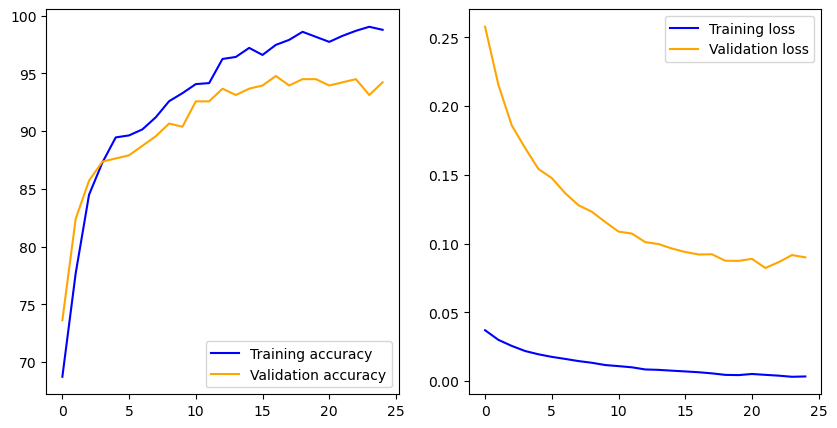

In [9]:
######### Visualise the accuracy and loss using line chart ######### 

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(train_accuracys, color='blue', label='Training accuracy')
ax[0].plot(validation_accuracys, color='orange', label='Validation accuracy')
ax[0].legend()

ax[1].plot(train_losses, color='blue', label='Training loss')
ax[1].plot(validation_losses, color='orange', label='Validation loss')
ax[1].legend()

plt.plot()
plt.savefig(f"models/resnet50_epoch25_acc_loss_94.23.jpg") #save the accuracy-loss fig into the models dir

In [5]:
######### Encapsulate the prediction function #########

'''
# For Mac users (the users should have GPU/mps))
def TUMOR_TYPE_PREDICTOR(model_path, img_path):

    img = cv2.imread(img_path)
    plt.imshow(img) #print the input image

    device = torch.device('mps' if torch.backends.mps.is_available () else 'cpu')
    transform = transforms.Compose([
        transforms.Resize([224,224]), #resize the image to the specified size
        transforms.ToTensor(), #convert the image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize the images 
    ])

    model = torch.load(model_path).to(device) #load the trained model
    model.eval()
    tumor_type = ["benign", "malignant"]
    image = torch.unsqueeze(transform(Image.open(img_path).convert("RGB")), dim=0).to(device)
    with torch.no_grad():
        pred = torch.argmax(model(image),dim=-1).cpu().numpy()[0]

    print(f"This breast cancer histopathology slide is predicted to be: {tumor_type[pred]}")

    return

'''


'''
# For non-Mac users (the users should have GPU/cuda)
def TUMOR_TYPE_PREDICTOR(model_path, img_path):

    img = cv2.imread(img_path)
    plt.imshow(img) #print the input image

    device = torch.device('cuda' if torch.cuda.is_available () else 'cpu')
    transform = transforms.Compose([
        transforms.Resize([224,224]), #resize the image to the specified size
        transforms.ToTensor(), #convert the image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize the images 
    ])

    model = torch.load(model_path).to(device) #load the trained model
    model.eval()
    tumor_type = ["benign", "malignant"]
    image = torch.unsqueeze(transform(Image.open(img_path).convert("RGB")), dim=0).to(device)
    with torch.no_grad():
        pred = torch.argmax(model(image),dim=-1).cpu().numpy()[0]

    print(f"This breast cancer histopathology slide is predicted to be: {tumor_type[pred]}")

    return
'''

# General
def TUMOR_TYPE_PREDICTOR(model_path, img_path):

    img = cv2.imread(img_path)
    plt.imshow(img) #print the input image

    transform = transforms.Compose([
        transforms.Resize([224,224]), #resize the image to the specified size
        transforms.ToTensor(), #convert the image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize the images 
    ])

    model = torch.load(model_path, map_location='cpu') #load the trained model
    model.eval()
    tumor_type = ["benign", "malignant"]
    image = torch.unsqueeze(transform(Image.open(img_path).convert("RGB")), dim=0)
    with torch.no_grad():
        pred = torch.argmax(model(image),dim=-1).cpu().numpy()[0]

    print(f"This breast cancer histopathology slide is predicted to be: {tumor_type[pred]}")

    return

This breast cancer histopathology slide is predicted to be: benign


'\nSome img_path of benign samples from the test datasets:\n/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_F-14-21998CD-400-003.png\n/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_TA-14-13200-400-015.png\n/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_TA-14-16184CD-400-022.png\n/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-004.png\n'

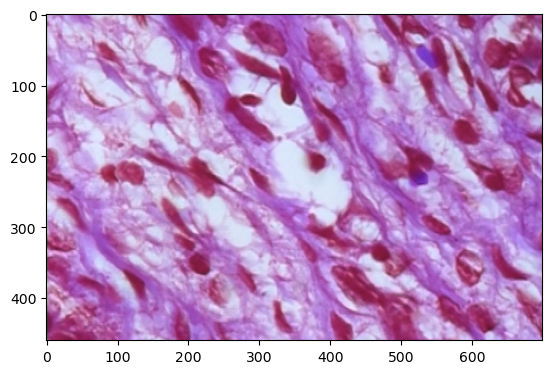

In [6]:
######### Use the image from the test datasets to check ######### 
TUMOR_TYPE_PREDICTOR(model_path='/Users/wangyufei/BIA4/project/models/resnet50_epoch25_94.23.pth', 
                     img_path='/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_TA-14-16184CD-400-022.png')

'''
Some img_path of benign samples from the test datasets:
/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_F-14-21998CD-400-003.png
/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_TA-14-13200-400-015.png
/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_TA-14-16184CD-400-022.png
/Users/wangyufei/BIA4/project/BreaKHis 400X/test/benign/SOB_B_A-14-22549CD-400-004.png
'''

This breast cancer histopathology slide is predicted to be: malignant


'\nSome img_path of malignant samples from the test datasets:\n/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_DC-14-4372-400-016.png\n/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_DC-14-14015-400-001.png\n/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_PC-14-19440-400-018.png\n/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_LC-14-13412-400-020.png\n'

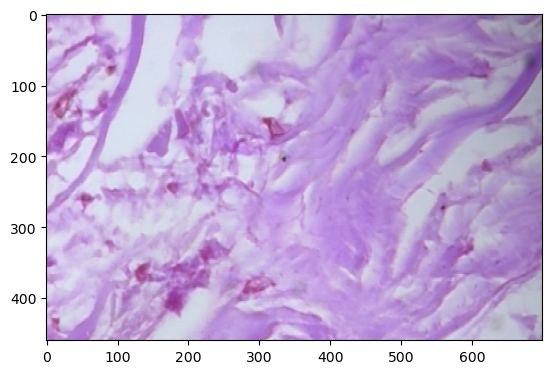

In [18]:
TUMOR_TYPE_PREDICTOR(model_path='/Users/wangyufei/BIA4/project/models/resnet50_epoch30_94.23.pth', 
                     img_path='/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_LC-14-13412-400-020.png')

'''
Some img_path of malignant samples from the test datasets:
/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_DC-14-4372-400-016.png
/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_DC-14-14015-400-001.png
/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_PC-14-19440-400-018.png
/Users/wangyufei/BIA4/project/BreaKHis 400X/test/malignant/SOB_M_LC-14-13412-400-020.png
'''